# **GPT-1 모델 구현 해보기**

## **Transformer와 비교해 변경이 필요한 부분**
### **1. 입력 및 임베딩 블록**
- 기존 방식은 Encoder 입력(질문), Decode 입력(`<SOS>` + 답변 shift (teacher forcing))
- 사인 함수(sinusoidal) 기반의 고정된 위치 인코딩을 사용한 것과 달리, 이 모델은 **위치 정보를 직접 학습하는 방식**을 채택
- 하나의 시퀀스로 합쳐서 단일 입력으로 넣음

### **2. Encoder Stack 블록**
- Encoder 전체 삭제

### **3. DecoderLayer**
- Cross-Attention 블록 제거
- Self-Attention은 항상 casual mask 적용

### **4. Attention 마스킹 블록**
- 기존에는 Decoder self-attention 에서만 look-ahead mask 적용
- 모든 레이어의 self-attention에 casual mask 필수

### **5. Output / LM Head 블록**
- 구조는 기존과 동일
- 차이는 모든 토큰 위치에서 다음 토큰을 예측

## **GPT 모델을 정상적으로 구성하였다 (model.summary, model.fit 결과 캡쳐 첨부)**

### **summary**
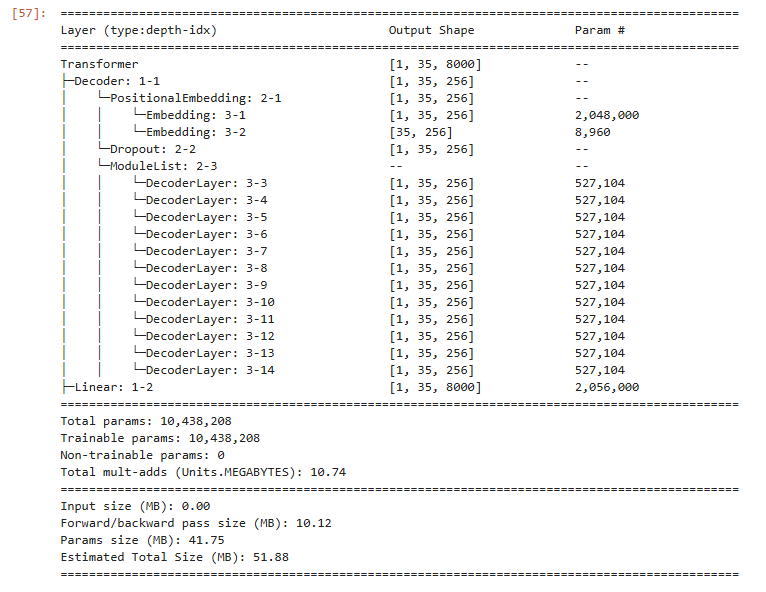

### **학습과정**
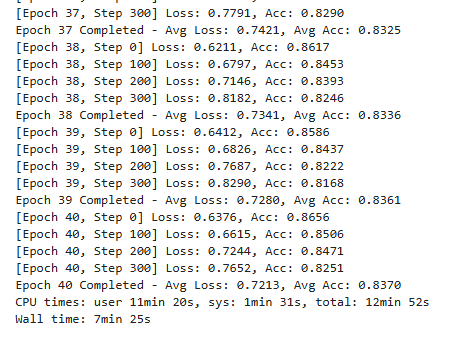

## **모델 입력 형태에 맞게 전처리 수행**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt

### **데이터 전처리**

In [2]:
path_to_dataset = os.path.join(os.getenv('HOME'), "work/songys_chatbot/data/ChatbotData.csv")
print("path_to_dataset:", path_to_dataset)

path_to_dataset: /home/jjeong3150/work/songys_chatbot/data/ChatbotData.csv


In [3]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.strip()
  
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (가-힣, 0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣0-9?.!,]+", " ", sentence)
    
    sentence = sentence.strip()
    return sentence

In [4]:
sample_sentence = "안녕하세요? 저는 학생입니다😊, nice to meet you!"

preprocessed_sentence = preprocess_sentence(sample_sentence)
print(preprocessed_sentence)

안녕하세요 ? 저는 학생입니다 , !


### **전처리 후 문장 특징**
- 앞뒤 공백 제거
- 문장부호 단어처럼 분리
- 두 개 이상 공백이 하나로 정리
- 한글, 숫자, 기본 기호(.?!,)만 남음
- 불필요한 노이즈(영어, 이모지, `@#$%^&*`)

In [5]:
def read_chatbotdata_data(path_to_dataset):
    with open(path_to_dataset, 'r', errors='ignore') as f:
        lines = f.readlines()

    pairs = []
    for line in lines[1:]:
        parts = line.strip().split(",")

        q_text = preprocess_sentence(parts[0])
        a_text = preprocess_sentence(parts[1])
        pairs.append(f"{q_text}<SEP>{a_text}")

    return pairs
        

In [6]:
pairs = read_chatbotdata_data(path_to_dataset)

print('전체 샘플 수 :', len(pairs))

전체 샘플 수 : 11823


In [7]:
pairs[0]

'12시 땡 !<SEP>하루가 또 가네요 .'

### **단어사전용 데이터 전처리**

In [8]:
import os
path_to_file = "korean-english-park.train.ko"

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [9]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

# plt.bar(range(max_len), sentence_length, width=1.0)
# plt.title("Sentence Length Distribution")
# plt.show()

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


In [10]:
def check_sentence_with_length(raw, length):
    count = 0

    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


In [11]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [12]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

# plt.bar(range(max_len), sentence_length, width=1.0)
# plt.title("Sentence Length Distribution")
# plt.show()

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


In [13]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

# plt.bar(range(max_len), sentence_length, width=1.0)
# plt.title("Sentence Length Distribution")
# plt.show()

### **SentencePiece 모델 학습**

In [14]:
# import sentencepiece as spm
# import os
# temp_file = 'korean-english-park.train.ko.temp'

# vocab_size = 8000

# with open(temp_file, 'w') as f:
#     for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
#         f.write(str(row) + '\n')



# spm.SentencePieceTrainer.Train(
#     "--input={} --model_prefix=korean_spm_bpe_8k --model_type=bpe --vocab_size={} --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --user_defined_symbols=<SEP>".format(temp_file, vocab_size)
# )

# !ls -l korean_spm*

### **SentencePiece 사용하기**

In [15]:
import sentencepiece as spm

sp = spm.SentencePieceProcessor()

# 이전 수업에서 만들었던 SentencePiece 모델 활용함
sp_model_path = "/home/jjeong3150/work/songys_chatbot/"
sp_model_name = "korean_spm_bpe_8k.model"
sp.Load(sp_model_path + sp_model_name)

True

In [16]:
for i in range(sp.get_piece_size()):
    print(i, sp.id_to_piece(i))
    if i == 10:
        break

0 <pad>
1 <s>
2 </s>
3 <unk>
4 <SEP>
5 ▁이
6 했다
7 ▁있
8 에서
9 ▁대
10 ▁사


In [17]:
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.load("korean_spm_bpe_8k.model")

print(sp.encode("안녕 <SEP> 반가워", out_type=str))

['▁안', '녕', '▁', '<SEP>', '▁반', '가', '워']


In [18]:
# 예제 문장
sentence = "안녕. 반가워 친구야. 잘 부탁해"

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)


전처리 후의 문장: 안녕 . 반가워 친구야 . 잘 부탁해
Tokenized: ['▁안', '녕', '▁', '.', '▁반', '가', '워', '▁친구', '야', '▁', '.', '▁잘', '▁부', '탁', '해']
Encoded: [172, 7998, 6683, 6687, 124, 6694, 7020, 1346, 6856, 6683, 6687, 718, 42, 7336, 6712]
Decoded: 안녕 . 반가워 친구야 . 잘 부탁해


#### **Token 기준으로 나눌 시 데이터 확인**

In [19]:

def data_profiling_token(pairs):
    from collections import Counter

    token_list = []
    for text in pairs:
        tokens = sp.encode(text, out_type=str)
            
        token_list.append(len(tokens))

        
    counter = Counter(token_list)

    return counter

In [20]:
token_counter = data_profiling_token(pairs)

In [21]:
import numpy as np

def calc_stats_from_freq(freq_dict):
    values = np.array(list(freq_dict.keys()), dtype=float)
    counts = np.array(list(freq_dict.values()), dtype=float)

    total = counts.sum()

    mean = np.average(values, weights=counts)

    variance = np.average((values - mean) ** 2, weights=counts)
    std = np.sqrt(variance)

    return mean, std, int(total)


In [22]:
import matplotlib.pyplot as plt

def plot_counter(counter, title="Length Distribution"):

    lengths = sorted(counter.keys())
    counts = [counter[l] for l in lengths]

    plt.figure()
    plt.bar(lengths, counts)
    plt.xlabel("Sentence Length")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

평균: 20.496066988074094
표준편차: 5.786420879248929
전체 개수: 11823
max_len: 35


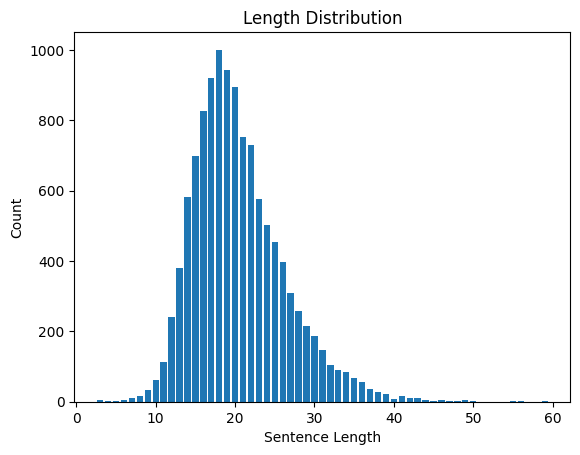

In [23]:
import math

mean, std, total = calc_stats_from_freq(token_counter)
print(f"평균: {mean}")
print(f"표준편차: {std}")
print(f"전체 개수: {total}")

k = 2.5
max_len = math.ceil( mean + k * std )
print(f"max_len: {max_len}")


plot_counter(token_counter)

#### **결론**
- max 토큰 수 35으로 설정(데이터 99% 이상 커버 가능)

In [24]:
class ChatBotDataset(Dataset):
    def __init__(self, pairs, sp, max_length=35):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for qa_text in pairs:
            # 1) 토크나이즈
            qa_ids = sp.EncodeAsIds(qa_text)
            
            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            # ---------------------------------------
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2
            # ---------------------------------------
            
            qa_tokens = [bos_id] + qa_ids + [eos_id]

            # 3) 길이 제한
            if len(qa_tokens) > max_length:
                continue

            # 4) 고정 길이 패딩
            qa_tokens += [0]*(max_length - len(qa_tokens))  # 0 -> <pad> 가정

            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = qa_tokens[:-1]
            target = qa_tokens[1:]

            self.data.append({
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return dec_input, target

In [25]:
dataset = ChatBotDataset(pairs, sp, max_length=35)

In [26]:
for decoder_input, decoder_label  in dataset:
    print("텐서 크기 :",decoder_input.size())
    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

텐서 크기 : torch.Size([34])
tensor([   1,  362, 6705, 6683,    3, 6683, 7579,    4, 6697, 6949, 6694,  143,
          24, 6988, 6821, 6683, 6687,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0])
12시  ⁇  !<SEP>하루가 또 가네요 .
tensor([ 362, 6705, 6683,    3, 6683, 7579,    4, 6697, 6949, 6694,  143,   24,
        6988, 6821, 6683, 6687,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0])
12시  ⁇  !<SEP>하루가 또 가네요 .


## **모델 구성하기**

### **Positional 임베딩**

In [27]:
class PositionalEmbedding(nn.Module):
    def __init__(self, vocab_size, max_len, d_model):
        super(PositionalEmbedding, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size, seq_length = x.shape

        token_vec = self.token_emb(x)
        pos_ids = torch.arange(seq_length, device=x.device)
        pos_vec = self.pos_emb(pos_ids).unsqueeze(0)

        x = token_vec + pos_vec

        return x

### **스케일드 닷 프로덕트 어텐션**

In [28]:
def scaled_dot_product_attention(query, key, value, mask=None):  # Q, K, V로 Attention(Q,K,V) 계산하기

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads  # Attention 공식의 √dₖ
    logits = matmul_qk / math.sqrt(depth)  # math.sqrt(depth) : Attention 학습이 터지지 않게 막는 안전장치

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

### **Multi Head Attention**

In [29]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads  # 헤드 개수 (예: 8)
        self.d_model = d_model  # 입력 임베딩 차원 (예: 512)

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads  # 각 헤드의 차원

        # 파이토치에서 Dense는 nn.Linear로 대응
        # 입력을 Q/K/V로 바꾸는 선형변환(Linear) 3개
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):  # d_model 하나짜리 벡터를 → 여러 개 head용 작은 벡터로 쪼개는 작업
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        # view는 “쪼개는 게 아니라, 메모리를 다른 모양으로 해석해서 보겠다”는 선언
        # 굳이 메모리 관점에서 보는 이유는 ‘속도와 확장성’ 때문
        # 복사가 많아지면 속도 폭락, VRAM 폭
        
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        # permute : 텐서의 축 순서를 바꾸는 함
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


### **룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)**

In [30]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [31]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [32]:
### 디코더
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.GELU(),                   # activation='GELU'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> GELU -> Dense)
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout2(ffn_out)
        out2 = self.norm3(out1 + ffn_out)  # 잔차 연결 + LayerNorm

        return out2

In [33]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 max_len,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        # self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, max_len=max_len, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + 포지셔널 인코딩 + 드롭아웃
        x = self.pos_embedding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (2) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, look_ahead_mask, padding_mask)

        return x

### **DataLoader 구성하기**

In [34]:
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

In [35]:
for decoder_input, decoder_label in dataloader:
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 34])
torch.Size([32, 34])


### **모델 정의 및 학습하기**

In [36]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 max_len,
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            max_len=max_len
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, dec_inputs):
        # 1) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 2) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            look_ahead_mask=look_ahead_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 3) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

In [37]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 12     # 디코더 층 수
D_MODEL = 256      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 8000 # 단어 집합 크기(예시)
max_len = 35

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_len = 35
)

print(model)

Transformer(
  (decoder): Decoder(
    (pos_embedding): PositionalEmbedding(
      (token_emb): Embedding(8000, 256)
      (pos_emb): Embedding(35, 256)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (dec_layers): ModuleList(
      (0-11): 12 x DecoderLayer(
        (self_mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (norm3): LayerNorm((256,), eps=1e

### **손실 함수(Loss function)**

In [38]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

### **커스텀 된 학습률(learning rate)**

In [39]:
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

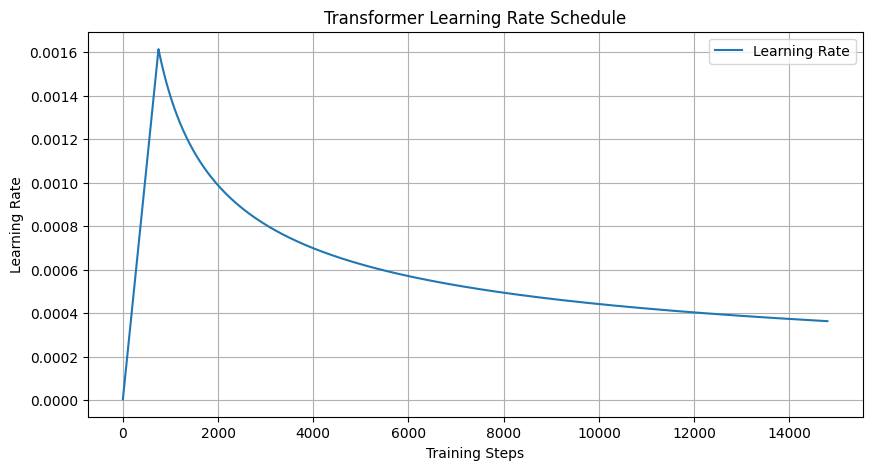

In [40]:
# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 750
# 전체 스텝의 5~10% 정도로 맞춤
# epoch 40으로 가정하면
# 1epoch = 11823 / 32 ≈ 370 (step)
# 370 X 40 ≈ 14,800 (step)
# 14,800 X 0.05 ≈ 740 (step)
# 약 warmup 스텝은 1000 정도로 결정

total_steps = 14800  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


### **모델 컴파일**

In [41]:
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9, lr=1.0)

# Scheduler 정의
# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

cuda


In [43]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [44]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 일정 스텝마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

In [45]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=40,  # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 9.1676, Acc: 0.0000
[Epoch 1, Step 100] Loss: 5.2642, Acc: 0.2503
[Epoch 1, Step 200] Loss: 4.6419, Acc: 0.3113
[Epoch 1, Step 300] Loss: 4.2928, Acc: 0.3328
Epoch 1 Completed - Avg Loss: 5.1399, Avg Acc: 0.2817
[Epoch 2, Step 0] Loss: 4.1929, Acc: 0.3279
[Epoch 2, Step 100] Loss: 3.8686, Acc: 0.3640
[Epoch 2, Step 200] Loss: 3.5302, Acc: 0.3986
[Epoch 2, Step 300] Loss: 3.6733, Acc: 0.3715
Epoch 2 Completed - Avg Loss: 3.7356, Avg Acc: 0.3732
[Epoch 3, Step 0] Loss: 3.5785, Acc: 0.3854
[Epoch 3, Step 100] Loss: 3.4399, Acc: 0.4027
[Epoch 3, Step 200] Loss: 3.5181, Acc: 0.3874
[Epoch 3, Step 300] Loss: 3.3166, Acc: 0.4095
Epoch 3 Completed - Avg Loss: 3.4520, Avg Acc: 0.3908
[Epoch 4, Step 0] Loss: 2.9516, Acc: 0.4368
[Epoch 4, Step 100] Loss: 3.1667, Acc: 0.4288
[Epoch 4, Step 200] Loss: 3.4131, Acc: 0.3688
[Epoch 4, Step 300] Loss: 3.0413, Acc: 0.4461
Epoch 4 Completed - Avg Loss: 3.1584, Avg Acc: 0.4138
[Epoch 5, Step 0] Loss: 2.7959, Acc: 0.4500
[Epoch 5, St

## **모델 평가하기**

In [46]:
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40


    # 전처리
    sentence = preprocess_sentence(sentence)
    print(sentence)
    # # 인코더 입력: [START] + 인코딩 + [END]
    # enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    # print(enc_input_ids)
    # # 차원 확장: (batch_size=1, seq_len)
    # enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [47]:
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )


    predicted_sentence = predicted_sentence.split('<SEP>')[0]
    
    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [48]:
sentence = '여행가고싶어'
sentence_generation(model, sentence, sp, device)

여행가고싶어
입력 : 여행가고싶어
출력 :  ⁇ 남이랑  ⁇ 꽃 놀이 가고 싶어 .


' ⁇ 남이랑  ⁇ 꽃 놀이 가고 싶어 .'

In [49]:
!pip install torchinfo


  Using cached torchinfo-1.8.0-py3-none-any.whl.metadata (21 kB)
Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)


In [57]:
import torch
from torchinfo import summary

vocab_size = 8000
x = torch.randint(0, vocab_size, (1, 35), dtype=torch.long)

summary(model, input_data=x, device="cpu")


Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [1, 35, 8000]             --
├─Decoder: 1-1                                [1, 35, 256]              --
│    └─PositionalEmbedding: 2-1               [1, 35, 256]              --
│    │    └─Embedding: 3-1                    [1, 35, 256]              2,048,000
│    │    └─Embedding: 3-2                    [35, 256]                 8,960
│    └─Dropout: 2-2                           [1, 35, 256]              --
│    └─ModuleList: 2-3                        --                        --
│    │    └─DecoderLayer: 3-3                 [1, 35, 256]              527,104
│    │    └─DecoderLayer: 3-4                 [1, 35, 256]              527,104
│    │    └─DecoderLayer: 3-5                 [1, 35, 256]              527,104
│    │    └─DecoderLayer: 3-6                 [1, 35, 256]              527,104
│    │    └─DecoderLayer: 3-7                 [1, 35, 256]       